## Compare ChebyKAN's ability in function interpolation with MLP (Multi-variable)

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ChebyKANLayer import ChebyKANLayer

In [9]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [10]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
        
# Define the ChebyKAN model
class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(2, 8, 8)
        self.chebykan2 = ChebyKANLayer(8, 16, 4)
        self.chebykan3 = ChebyKANLayer(16, 1, 4)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        x = self.chebykan3(x)
        return x

Epoch 1/2000, MLP Loss: 0.9171, ChebyKAN Loss: 1.1281
Epoch 101/2000, MLP Loss: 0.4379, ChebyKAN Loss: 0.1850
Epoch 201/2000, MLP Loss: 0.3627, ChebyKAN Loss: 0.1661
Epoch 301/2000, MLP Loss: 0.3019, ChebyKAN Loss: 0.1616
Epoch 401/2000, MLP Loss: 0.2799, ChebyKAN Loss: 0.1429
Epoch 501/2000, MLP Loss: 0.2581, ChebyKAN Loss: 0.1232
Epoch 601/2000, MLP Loss: 0.2411, ChebyKAN Loss: 0.1076
Epoch 701/2000, MLP Loss: 0.2290, ChebyKAN Loss: 0.0977
Epoch 801/2000, MLP Loss: 0.2215, ChebyKAN Loss: 0.0930
Epoch 901/2000, MLP Loss: 0.2221, ChebyKAN Loss: 0.0874
Epoch 1001/2000, MLP Loss: 0.2092, ChebyKAN Loss: 0.0863
Epoch 1101/2000, MLP Loss: 0.2258, ChebyKAN Loss: 0.0809
Epoch 1201/2000, MLP Loss: 0.2053, ChebyKAN Loss: 0.0788
Epoch 1301/2000, MLP Loss: 0.1912, ChebyKAN Loss: 0.0797
Epoch 1401/2000, MLP Loss: 0.2074, ChebyKAN Loss: 0.0768
Epoch 1501/2000, MLP Loss: 0.1926, ChebyKAN Loss: 0.0750
Epoch 1601/2000, MLP Loss: 0.3164, ChebyKAN Loss: 0.0735
Epoch 1701/2000, MLP Loss: 0.1846, ChebyKAN

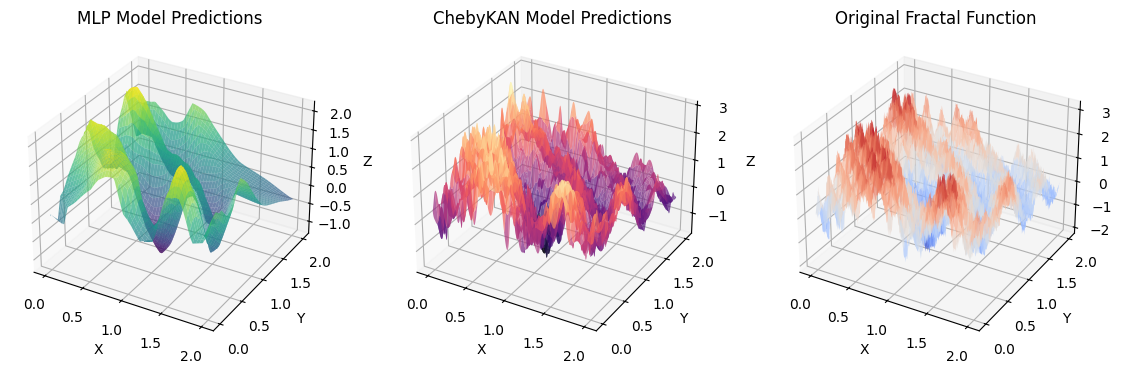

In [11]:
# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

# Instantiate the models
mlp_model = SimpleMLP()
cheby_model = ChebyKAN()

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)

# Train the models
epochs = 2000
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_mlp.step()

    # ChebyKAN Training
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train_2d)
    loss_cheby = criterion(outputs_cheby, y_train_2d)
    loss_cheby.backward()
    optimizer_cheby.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, ChebyKAN Loss: {loss_cheby.item():.4f}')

# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_mlp = mlp_model(x_test_2d).detach().numpy()
y_pred_cheby = cheby_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax1.set_title('MLP Model Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_cheby.reshape(X_test.shape), cmap='magma', alpha=0.7, label='ChebyKAN Prediction')
ax2.set_title('ChebyKAN Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.show()